In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
path = "./data/car.csv"

df = pd.read_csv(path)
len(df)

11914

In [3]:
# Preview by transposing the columns.
df.head(3).T

,0,1,2
Make,BMW,BMW,BMW
Model,1 Series M,1 Series,1 Series
Year,2011,2011,2011
Engine Fuel Type,premium unleaded (required),premium unleaded (required),premium unleaded (required)
Engine HP,335.0,300.0,300.0
Engine Cylinders,6.0,6.0,6.0
Transmission Type,MANUAL,MANUAL,MANUAL
Driven_Wheels,rear wheel drive,rear wheel drive,rear wheel drive
Number of Doors,2.0,2.0,2.0
Market Category,"Factory Tuner,Luxury,High-Performance","Luxury,Performance","Luxury,High-Performance"


In [4]:
# Check for null values.
df.isnull().sum()

Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              69
Engine Cylinders       30
Transmission Type       0
Driven_Wheels           0
Number of Doors         6
Market Category      3742
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64

In [5]:
# Check column types.
df.dtypes

Make                  object
Model                 object
Year                   int64
Engine Fuel Type      object
Engine HP            float64
Engine Cylinders     float64
Transmission Type     object
Driven_Wheels         object
Number of Doors      float64
Market Category       object
Vehicle Size          object
Vehicle Style         object
highway MPG            int64
city mpg               int64
Popularity             int64
MSRP                   int64
dtype: object

In [6]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

string_columns = list(df.dtypes[df.dtypes == "object"].index)
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(" ", "_")

In [7]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


<AxesSubplot:xlabel='msrp', ylabel='Count'>

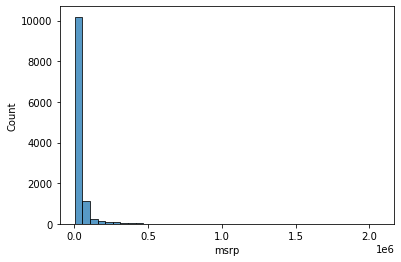

In [8]:
# Long tail is observed on the right. The solution is to apply log transformation to remove the long tail.
sns.histplot(df.msrp, bins=40)

<AxesSubplot:xlabel='msrp', ylabel='Count'>

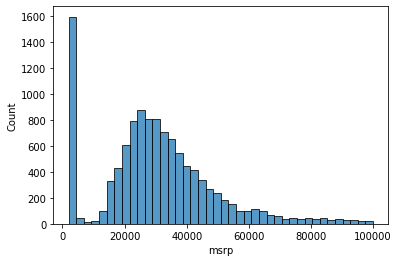

In [9]:
sns.histplot(df.msrp[df.msrp < 100000], bins=40)

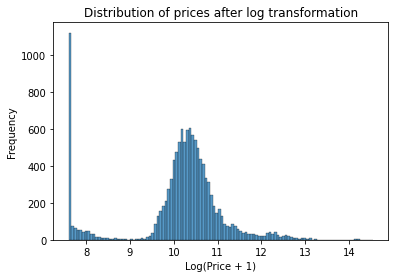

In [10]:
# y_new = log(y + 1) # log 0 is infinity, but log 1 is 0

log_price = np.log1p(df.msrp)
sns.histplot(log_price)
plt.xlabel("Log(Price + 1)")
plt.ylabel("Frequency")
plt.title("Distribution of prices after log transformation")
plt.show()

## Splitting dataset

Split the data so that
- 20% of data goes to validation
- 20% goes to test
- 60% goes to train

In [11]:
np.random.seed(2)  # Ensure the result is deterministic.

n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train : n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val :].copy()

In [12]:
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

del df_train["msrp"]
del df_val["msrp"]
del df_test["msrp"]

## Training the Model

After splitting the dataset into training, validation and testing data, we are ready to train the model.

Since we want to predict the price of the car, this problem falls naturally as a regression problem.

\$w = (X^T \cdot X)^{-1} \cdot (X^T) \cdot y\$

In [13]:
def train_linear_regression(X, y):
    """
    w = (XT.X)^-1 . (XT) . y
    """
    # Adding the dummy column.
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    # Normal equation formula.
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    # Return bias weight and the rest of the weight.
    return w[0], w[1:]

In [14]:
base = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg", "popularity"]


def prepare_X(df):
    df_num = df[base]
    # Fill missing values with 0
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

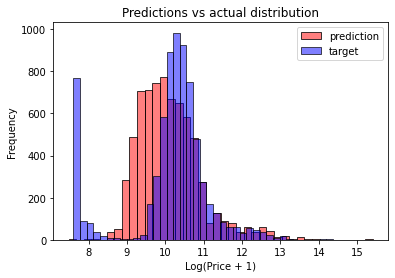

In [15]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)

sns.histplot(y_pred, label="prediction", color="red", alpha=0.5, bins=40)
sns.histplot(y_train, label="target", color="blue", alpha=0.5, bins=40)
plt.ylabel("Frequency")
plt.xlabel("Log(Price + 1)")
plt.title("Predictions vs actual distribution")
plt.legend()

In [16]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [17]:
rmse(y_train, y_pred)

0.7554192603920132

In [18]:
X_val = prepare_X(df_val)
# w_0, w = train_linear_regression(X_val, y_val) ?
y_pred = w_0 + X_val.dot(w)

rmse(y_val, y_pred)

0.761653099130156

### Simple feature engineering

Create a new feature `age` from `year`. The newer the car, the more expensive it should be.

In [19]:
df_train.year.max()

2017

In [20]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()
    df["age"] = 2017 - df.year
    features.append("age")

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [21]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

# The error decreases with the new age column.
print("validation: ", rmse(y_val, y_pred))

validation:  0.5172055461058299


In [22]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df["age"] = 2017 - df.year
    features.append("age")

    for v in [2, 3, 4]:
        feature = "num_doors_%s" % v
        df[feature] = (df["number_of_doors"] == v).astype(int)
        features.append(feature)

    for v in ["chevrolet", "ford", "volkswagen", "toyota", "dodge"]:
        feature = "is_make_%s" % v
        df[feature] = (df["make"] == v).astype(int)
        features.append(feature)

    for v in [
        "regular_unleaded",
        "premium_unleaded_(required)",
        "premium_unleaded_(recommended)",
        "flex-fuel_(unleaded/e85)",
    ]:
        feature = "is_type_%s" % v
        df[feature] = (df["engine_fuel_type"] == v).astype(int)
        features.append(feature)

    for v in ["automatic", "manual", "automated_manual"]:
        feature = "is_transmission_%s" % v
        df[feature] = (df["transmission_type"] == v).astype(int)
        features.append(feature)

    for v in [
        "front_wheel_drive",
        "rear_wheel_drive",
        "all_wheel_drive",
        "four_wheel_drive",
    ]:
        feature = "is_driven_wheens_%s" % v
        df[feature] = (df["driven_wheels"] == v).astype(int)
        features.append(feature)

    for v in ["crossover", "flex_fuel", "luxury", "luxury,performance", "hatchback"]:
        feature = "is_mc_%s" % v
        df[feature] = (df["market_category"] == v).astype(int)
        features.append(feature)

    for v in ["compact", "midsize", "large"]:
        feature = "is_size_%s" % v
        df[feature] = (df["vehicle_size"] == v).astype(int)
        features.append(feature)

    for v in ["sedan", "4dr_suv", "coupe", "convertible", "4dr_hatchback"]:
        feature = "is_style_%s" % v
        df[feature] = (df["vehicle_style"] == v).astype(int)
        features.append(feature)

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [23]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print("validation: ", rmse(y_val, y_pred))

validation:  55.22691647401435


In [24]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)

    return w[0], w[1:]

In [25]:
for r in [0, 0.001, 0.01, 0.1, 1, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r)
    print(r, w_0, w[13], w[21])

0 8115744691019874.0 -7.101290592624596 -8115744691023588.0
0.001 7.1953790893732705 -0.10219237063061223 1.8134462631611798
0.01 7.181697276886033 -0.10216341824773444 1.8101483000767682
0.1 7.054109288941499 -0.10187498932842298 1.7770086839776698
1 6.219919389575023 -0.09923859645427019 1.559323290835688
10 4.3899243405183395 -0.09047293315956109 1.0754918772560533


In [26]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.001)

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print("validation: ", rmse(y_val, y_pred))

validation:  0.4602267628312078


## Custom

In [80]:
from sklearn.linear_model import LinearRegression

In [81]:
df = pd.read_csv(path)
df.head().T

,0,1,2,3,4
Make,BMW,BMW,BMW,BMW,BMW
Model,1 Series M,1 Series,1 Series,1 Series,1 Series
Year,2011,2011,2011,2011,2011
Engine Fuel Type,premium unleaded (required),premium unleaded (required),premium unleaded (required),premium unleaded (required),premium unleaded (required)
Engine HP,335.0,300.0,300.0,230.0,230.0
Engine Cylinders,6.0,6.0,6.0,6.0,6.0
Transmission Type,MANUAL,MANUAL,MANUAL,MANUAL,MANUAL
Driven_Wheels,rear wheel drive,rear wheel drive,rear wheel drive,rear wheel drive,rear wheel drive
Number of Doors,2.0,2.0,2.0,2.0,2.0
Market Category,"Factory Tuner,Luxury,High-Performance","Luxury,Performance","Luxury,High-Performance","Luxury,Performance",Luxury


In [85]:
df.columns = df.columns.str.lower().str.replace(" ", "_")

string_columns = df.columns[df.dtypes == "object"]

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(" ", "_")

df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


In [88]:
print(df.isnull().sum())

df.fillna(0, inplace=True)

df.isnull().sum()

make                 0
model                0
year                 0
engine_fuel_type     0
engine_hp            0
engine_cylinders     0
transmission_type    0
driven_wheels        0
number_of_doors      0
market_category      0
vehicle_size         0
vehicle_style        0
highway_mpg          0
city_mpg             0
popularity           0
msrp                 0
dtype: int64


make                 0
model                0
year                 0
engine_fuel_type     0
engine_hp            0
engine_cylinders     0
transmission_type    0
driven_wheels        0
number_of_doors      0
market_category      0
vehicle_size         0
vehicle_style        0
highway_mpg          0
city_mpg             0
popularity           0
msrp                 0
dtype: int64

In [112]:
X = df[[col for col in df.columns if col != "msrp"]]
y = np.log1p(df["msrp"].values)

X = pd.get_dummies(X)
X.shape

(11914, 1080)

In [113]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [114]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_test, y_test)

0.9705631543493081

In [115]:
from sklearn.metrics import mean_squared_error

y_pred = reg.predict(X_test)
mean_squared_error(y_test, y_pred)

0.03521825899159064

In [116]:
reg.coef_

array([ 0.04241406,  0.00116946,  0.01307132, ...,  0.05509586,
       -0.03365109, -0.01878024])

In [117]:
reg.intercept_

-75.01858735180767

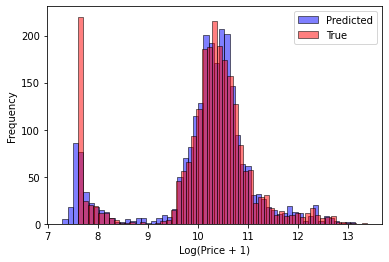

In [121]:
sns.histplot(y_pred, color="blue", alpha=0.5, label="Predicted")
sns.histplot(y_test, color="red", alpha=0.5, label="True")
plt.xlabel("Log(Price + 1)")
plt.ylabel("Frequency")
plt.legend()